<a href="https://colab.research.google.com/github/vikashsumit/vikashsumit/blob/main/GRPO_Fine_Tuning_for_Arithmetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ▂▂▂▂▂▂▂▂▂▂▂▂

# GRPO Tutorial: Fine-tuning for Arithmetic with Programmatic Rewards

This Notebook applies GRPO to fine-tune a Qwen 2.5 model's responses to basic arithmetic problems.

It leverages the `GRPOTrainer` class from Hugging Face's Transformer reinforcement learning library, `trl`.

Here's one example of the base model's behavior. It correctly answers that 13*72 = 936.


<font color="navy" size="+2">⎯⎯⎯⎯⎯⎯⎯⎯ User ⎯⎯⎯⎯⎯⎯⎯⎯</font>


> <font color="navy">What is 13 times 72?

<font color="navy" size="+2">⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯</font>

<br/>

<font color="olive" size="+2">⎯⎯⎯⎯⎯⎯⎯⎯ Assistant ⎯⎯⎯⎯⎯⎯⎯⎯</font>

> To find the product of $13$ and $72$, you can simply multiply them together:
>
> $$ 13 \times 72 = 936 $$
>
> So, $13$ times $72$ equals $936$.

<font color="olive" size="+2">⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯</font>
<br/>

Its "explanation" ('you can simply multiply them together') isn't particularly helpful, but the answer is correct.

> _Note: We could try crafting a reward to address its response style--that would be an example of **preference** tuning._

<br/>

The model is also capable of showing its work--in the below alternative response it correctly decomposes the problem.

<font color="olive" size="+2">⎯⎯⎯⎯⎯⎯⎯⎯ Assistant ⎯⎯⎯⎯⎯⎯⎯⎯</font>

> To solve $ 13 \times 72 $:
>
> $$
> \begin{align*}
> 13 \times 72 &= 13 \times \left(70 + 2\right) \\
> &= 13 \times 70 + 13 \times 2 \\
> &= 910 + 26 \\
> &= 936
> \end{align*}
> $$
>
> Therefore, $ 13 \times 72 = 936 $.

<font color="olive" size="+2">⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯</font>

Oddly enough, though, it's typically these kinds of "break the problem down into steps" responses which fail.

For example, below is the model's response to "What is 696 minus 408?" (it should be 288).

<font color="olive" size="+2">⎯⎯⎯⎯⎯⎯⎯⎯ Assistant ⎯⎯⎯⎯⎯⎯⎯⎯</font>

>To solve the problem of subtracting 408 from 696, you can follow these steps:
>
>1. Start with the number 696.
>2. Subtract 408 from it.
>
>Let's do this step-by-step:
>
>$$ 696 - 408 = (696 - 400) + (-408) $$
>
>First, calculate $ 696 - 400 $:
>
>$$ 696 - 400 = 296 $$
>
>Next, take the result and subtract 408:
>
>$$ 296 - 408 = -112 $$
>
>So, the final answer is:
>
> $$
> \boxed{-112}
> $$

<font color="olive" size="+2">⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯</font>
<br/>

(That's <font color="maroon">incorrect</font>, it's: `288`)

<br/>

We don't necessarily need to leverage this insight to improve the model's performance, though.

In this Notebook, we'll use Reinforcement Learning to have the model effectively _sort out for itself_ what to do differently in order to improve its accuracy.





## 1 - Setup

Start by installing Hugging Face's `trl` library, since Colab doesn't have it built in.

The library documentation is [here](https://trl.readthedocs.io/en/latest/).

In [ ]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 32.0 MB/s eta 0:00:00


We'll use the 500M parameter, instruction-tuned version of Qwen 2.5.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load a lightweight Qwen model
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    padding_side = 'left',  # Important for batch generation.
                            # Gives us: "(padding) (prompt) (completion)"
)

# Set the pad token.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map="auto",
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [ ]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2

## 2 - Training Data

To match the problem difficulty to the small Qwen model's capabilities, we will:

* Limit the task to multiplication, addition, and subtraction of integers.
* Limit the size of the operands:
    * `< 100` for multiplication and
    * `< 1000` for add/subtract.

### 2.1. Templates

Rather than use a fixed training set, we'll define templates that we can fill
with random numbers. This will allow us to quickly adapt the training data to
the capabilities of the model.

To create a sample, we'll randomly select one of the prompt templates, then pick two random integers (with a maxinum number digits) to use in the operation.

Here are some examples:

```
('What is 89 minus 773?', -684.0)
('What is the product of 65 and 43?', 2795.0)
("What's the result of 433 minus 858?", -425.0)
('Calculate the product of 8 and 69.', 552.0)
('What is 201 plus 94?', 295.0)
('What is 526 plus 975?', 1501.0)
("What's the result of 735 minus 761?", -26.0)
('What is 717 minus 786?', -69.0)
('Calculate the sum of 513 and 128.', 641.0)
("What's the result of 839 plus 450?", 1289.0)
```

In [ ]:
import numpy as np

templates = [
    ("What is {} multiplied by {}?", "*"),
    ("Calculate the product of {} and {}.", "*"),
    ("What is the product of {} and {}?", "*"),
    ("How much is {} times {}?", "*"),

    ("What is {} plus {}?", "+"),
    ("Calculate the sum of {} and {}.", "+"),
    ("What's the result of {} plus {}?", "+"),
    ("How much is {} plus {}?", "+"),

    ("What is {} minus {}?", "-"),
    ("Compute {} minus {}.", "-"),
    ("What's the result of {} minus {}?", "-"),
    ("How much is {} minus {}?", "-"),
]

def get_random_problem(rng, templates, max_operand_add=1000, max_operand_mult=100):
    """Picks a random template and two random integers and returns the formatted question and its numerical answer."""

    # Pick a random template.
    template_i = rng.integers(0, len(templates))
    q, op = templates[template_i]

    # Determine maximum operand value.
    if op == "*":
        max_num = max_operand_mult
    elif op == "+" or op == "-":
        max_num = max_operand_add

    # Fill the template with 2 random numbers < max_num
    val1 = rng.integers(0, max_num)
    val2 = rng.integers(0, max_num)

    # Calculate the numerical answer.
    if op == "*":
        answer = val1 * val2
    elif op == "+":
        answer = val1 + val2
    elif op == "-":
        answer = val1 - val2
    else:
        raise ValueError(f"Unknown op: {op}")

    # Fill in the question template.
    question = q.format(val1, val2)

    return question, float(answer)

Check some examples

In [ ]:
rng42 = np.random.default_rng(42)

for _ in range(10):
    print(
        get_random_problem(
            rng42,
            templates,
            max_operand_add=1000,
            max_operand_mult=100
        )
    )

('Calculate the product of 77 and 65.', 5005.0)
('Calculate the sum of 433 and 858.', 1291.0)
('Calculate the product of 69 and 20.', 1380.0)
('Calculate the product of 52 and 97.', 5044.0)
('What is 761 minus 717?', 44.0)
('Compute 513 minus 128.', 385.0)
("What's the result of 450 minus 500?", -50.0)
('What is 182 plus 926?', 1108.0)
('Compute 643 minus 402.', 241.0)
('Compute 545 minus 443.', 102.0)


### 2.2. System Prompt

The most time-consuming step by far in this training process will be generating the rollouts.

A system prompt may not be necessary here, and we can speed up training by leaving it empty to conserve tokens.

In [ ]:
sys_prompt = ""

### 2.3. Datasets

Now we can generate our training and validation sets.


**Sample Format**

The GRPOTrainer accepts the dataset in multiple formats.

Instruction-tuned models usually define a `chat_template` in their tokenizer. You can manually construct the prompt string by calling `tokenizer.apply_chat_template`, or we can let the Trainer handle this and specify the standard message-list format. We'll do the latter.

**Specifying Data for Reward Functions**

The only required property of the dataset sample is "prompt"--there's no standard 'target' since that's determined by your reward function(s).

Whatever additional information your reward function needs (in our case, the "answer") should be included as an attribute of the sample.

The Trainer will inspect the argument list of your reward functions and match those to the dataset sample attributes and pass them in.

**Create Datasets**

This function generates the samples, formats them properly, and wraps them in a Dataset object.

In [ ]:
from datasets import Dataset
import numpy as np

def create_problem_dataset(num_samples, sys_prompt=None, seed=42):

    # Set the seed.
    rng = np.random.default_rng(seed)

    data = []

    # For each requested sample,
    for _ in range(num_samples):

        # Generate a math problem
        question, answer = get_random_problem(rng, templates)

        # Use the standard conversational format.
        if sys_prompt:
            messages = [
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": question},
            ]
        else:
            messages = [
                {"role": "user", "content": question},
            ]

        # The sample must include a `prompt`. Any other attributes will be
        # passed to reward functions if their argument list contains a variable
        # of the same name.
        sample = {
            "prompt": messages,  # In message-list format.
            "answer": answer     # The correct numerical answer.
        }

        data.append(sample)

    return(Dataset.from_list(data))

Create training and validation sets.

The training set is larger than it needs to be--the amount of data actually seen is controlled by the `max_steps` training argument.

We'll include a validation set primarily because the average training reward is noisy. For a small training run like ours, we'll want to periodically evaluate over a larger number of examples (our validation set) to get a smoother / more stable indicator of training progress.

In [ ]:
# Create the training, validation, and test datasets
train_dataset = create_problem_dataset(2000, seed=42)
val_dataset   = create_problem_dataset(  64, seed=999)

## 3 - Reward

#### 🔹 reward_correctness

We'll train the model using a single simple reward function. It:

1. Treats the last number in the response as the answer.
2. Rewards 1.0 for correct and 0.0 for incorrect.

In [ ]:
import re
from typing import Optional

# Matches all numbers in a string
_ALL_NUMS_RE = re.compile(
    r"([+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)"
)

# `prompts` and `completions` are standard arguments. `answer` is custom
# and will contain the corresponding values from the "answer" column of our
# dataset.
def reward_correctness(prompts, completions, answer, **kwargs):
    """
    Identifies the last number in the text as the answer, and rewards
    1.0 for an exact match to the correct answer, and 0.0 otherwise.
    """
    rewards = []

    # For each completion to score,
    for completion_msg, tgt_answer in zip(completions, answer):

        # Note: `completion_msg` is a message dictionary with:
        #       {"role": "assistant", "content": <the completion string>}

        # Find all numbers
        matches = _ALL_NUMS_RE.findall(completion_msg[0]["content"])

        # If no numbers were found, reward is 0.
        if not matches:
            reward = 0.0

        # Otherwise, check the answer.
        else:
            # Parse the last number in the text as the answer. Cast and round.
            last_number = int(float(matches[-1]))

            # Compare to the target.
            reward = 1.0 if last_number == tgt_answer else 0.0

        rewards.append(reward)

    return rewards

## 4 - Initial Performance

The training code will periodically evaluate our performance on the evaluation set. However, it does so with the same decoding strategy as it uses for training, which focused on producing variety.

For measuring the model's accuracy at arithmentic, it makes more sense to do strict greedy decoding and use the model's most confident prediction. The below function does just that, and reports the model's current accuracy.

We'll measure it here before training, then again after training is complete, and log the generations in both cases so that we can make a "before-and-after" comparison.


In [ ]:
import os
from transformers import pipeline
from tqdm.auto import tqdm

def generate_validation_completions(model, tokenizer, val_dataset, reward_func, output_file, num_samples=64):
    """
    Generate validation completions, compute rewards, and write results to a markdown file.

    Args:
        model: The model to use for generation
        tokenizer: The tokenizer to use
        val_dataset: Validation dataset with 'prompt' and 'answer' fields
        reward_func: Reward function to compute rewards
        output_file: Path to the markdown file to write results
        num_samples: Number of samples to display in the output (default: 64)

    Returns:
        rewards: Array of reward values
    """
    # Text generation pipeline
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device_map="auto"
    )

    # Run the validation set.
    results = pipe(
        [p for p in val_dataset["prompt"]], # Convert from 'Column' to list.
        batch_size=32,
        return_full_text=False,
        max_new_tokens=256,
        temperature=0.0,    # Greedy decoding for test set.
        do_sample=False
    )

    # `completions` has the same structure, just with the `role` added and
    # `generated_text` renamed to `content`.
    test_completions = []
    for r in results:
        # Corrected: Append the dictionary directly, not a list containing the dictionary
        test_completions.append([{"role": "assistant", "content": r[0]["generated_text"]}])

    # Compute Rewards
    rewards = reward_func(
        prompts     = val_dataset["prompt"],
        completions = test_completions,
        answer      = val_dataset["answer"]
    )

    # Calculate accuracy
    num_correct = np.sum(rewards)
    accuracy = num_correct / len(rewards) * 100.0

    # Ensure the output directory exists
    output_dir = os.path.dirname(output_file)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    # Write results to file
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(f"Val set accuracy with greedy decoding: {int(num_correct)} / {len(rewards)} ({accuracy:.3}%)\n\n")

        i = 0
        for r, a, reward in zip(results[:num_samples], val_dataset["answer"][:num_samples], rewards[:num_samples]):
            f.write(f"\n-------- {i} --------\n")
            f.write(r[0]["generated_text"] + "\n")
            f.write(f"Correct Answer: {a}   Reward: {reward}\n")
            i += 1

        f.write(f"\n\nVal set accuracy with greedy decoding: {int(num_correct)} / {len(rewards)} ({accuracy:.3}%)\n")

    # Also print to console
    print(f"Val set accuracy with greedy decoding: {int(num_correct)} / {len(rewards)} ({accuracy:.3}%)")
    print(f"Results written to {output_file}")

    return rewards

In [ ]:
# Generate baseline validation completions
baseline_val_rewards = generate_validation_completions(
    model=model,
    tokenizer=tokenizer,
    val_dataset=val_dataset,
    reward_func=reward_correctness,
    output_file="./logs/baseline.md"
)

Device set to use cuda:0


Val set accuracy with greedy decoding: 55 / 64 (85.9%)
Results written to ./logs/baseline.md


## 5 - Training

RL training can be difficult to debug because of how many potential sources of issues there are.

This makes logging especially important. GRPOTrainer will automatically report a variety of helpful tracking signals for us; we'll use Weights and Biases for this.

`wandb.login()` will automatically detect your API key if you save it to the environment variable `WANDB_API_KEY`.

Or, in Colab, you can use the "Secrets" panel to define a variable to use across your notebooks.

In [ ]:
import wandb

# Check if running in Colab
try:
    from google.colab import userdata
    is_colab = True
except ImportError:
    is_colab = False

if is_colab:
    wandb.login(key=userdata.get('wandb_api_key'))
else:
    # For non-Colab environments, wandb will use WANDB_API_KEY from environment
    wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chrismccormick to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Set wandb project name via environment variable (GRPOConfig project parameter
# may not always be properly passed to wandb.init() internally)
os.environ["WANDB_PROJECT"] = "grpo-arithmetic"

### 5.1. Configuration

**Hundreds of Settings**

The `GRPOConfig` class and the `GRPOTrainer` constructor together have literally _hundreds_ of arguments.

While the defaults are reasonable, that doesn't mean they're optimal or safe to ignore.

To be successful, I'd recommend gradually familiarizing yourself with as many of them as you can.

Documentation:
* Standard transformers [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
* [GRPOConfig](https://huggingface.co/docs/trl/main/en/grpo_trainer#trl.GRPOConfig) extends these (and overwrites some defaults).

**Trainer Challenges**

The benefit to the Trainer classes is that you can get going quickly and successfully while you continue to become more knowledgable and proficient.

As your project matures, you'll begin to find that the Trainers can be difficult to customize and, sincerely, a nightmare to debug.

Their opacity and ongoing changes cause coding agents to struggle as well.

Eventually, I think you'll want to choose one of two philosophies/approaches:
1. Trade performance for simplicity. Don't fight the library; work within its limitations, and enjoy the benefits: easily test different models, datasets, and supported techniques.
2. Write your own PyTorch code for full control, performance, and transparency into issues. It's easy to customize and debug, but higher effort to make major changes.

#### 🔹 GRPOConfig


This is the standard `TrainingArguments` class, extended with GRPO-specific attributes.

In [ ]:
from trl import GRPOConfig

# ==================================
#     GRPO Training Configuration
# ==================================

training_args = GRPOConfig(

    # ==== Logging ====
    output_dir     = "qwen-grpo-arithmetic",
    logging_steps  = 10,
    report_to      = "wandb",  # <--- Do this!
    project        = "grpo-arithmetic",

    shuffle_dataset       = False,  # For reproducibility.

    # ==== GRPO & Rollouts ====
    temperature =   1.0,  # Set to a high value for exploration. Default is 1.0.
    top_p =         1.0,  # Sample from entire vocabulary. Default is 1.0.

    max_completion_length = 256,
    num_generations       = 4, # Group size / number of rollouts. Default is 4.
    steps_per_generation  = 2, # Number of prompts to include in a training step.
    generation_batch_size = None,
    per_device_train_batch_size = 8,  # num_generations * steps_per_generation
    gradient_accumulation_steps = 1,

    beta =        1e-5,  # KL-divergence, defaults to 0. DS-R1 used 1e-3.
                         # I set it to a tiny value so that KL at least gets logged as a metric.

    loss_type     = 'dapo', # Default is actually 'dapo', not 'grpo'.
    scale_rewards = False,  # Disable division by std-dev

    # If we had used multiple reward functions, you can optionally specify a
    # list of weights here to control their respective impacts.
    #reward_weights = reward_weights

    # ==== Evaluation Settings ====
    eval_strategy   = "steps",
    eval_steps      = 20,
    eval_on_start   = True,
    per_device_eval_batch_size = 32, # There's plenty of memory.
    num_generations_eval       = 4,

    # Note that, unfortunately, there is not a way to specify an alternate
    # decoding strategy for the evaluation step.

    # ==== Optimizer ====
    max_steps     = 60,
    learning_rate = 1e-5,   # Default is 1e-6
    adam_beta1    = 0.9,
    adam_beta2    = 0.999,
    weight_decay  = 0.0,  # Default 0.0
    max_grad_norm = 1.0,  # Default 1.0
    lr_scheduler_type = "constant_with_warmup",  # Default is linear decay
    warmup_steps      = 10, # Default is to use warmup_ratio = 0.1

    # ==== Performance ====
    bf16          = True,
    use_vllm      = False, # Faster generation
    torch_compile = False, # Faster training
)

#### 🔹 GRPOTrainer

The `GRPOTrainer` initialization looks nearly identical to the SFT `Trainer`; the key difference is the `reward_funcs` argument.

With SFT we specificy desired input and output pairs. Here, all we need are inputs and a function that can score them.

In [ ]:
from trl import GRPOTrainer

# ==============================
#      Initialize Trainer
# ==============================

trainer = GRPOTrainer(
    model           = model,
    reward_funcs    = [reward_correctness], # <-- What makes this RL
    args            = training_args,
    train_dataset   = train_dataset,
    eval_dataset    = val_dataset,
)

The model is already on multiple devices. Skipping the move to device specified in `args`.


This Notebook currently only uses a single reward function, but the GRPOTrainer can accept a list of them, and will combine the rewards by computing a weighted sum (using the `reward_weights` from the training arguments).

### 5.2. Training Loop

In [ ]:
print("Starting GRPO Training...")
print(f"Sampling {training_args.num_generations} generations per prompt.")

trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Starting GRPO Training...
Sampling 4 generations per prompt.


Step,Training Loss,Validation Loss
0,No log,0.110562
20,0.002000,-0.001016
40,0.000000,-0.002021
60,-0.000100,-0.000153


TrainOutput(global_step=60, training_loss=0.014317338223433278, metrics={'train_runtime': 186.9601, 'train_samples_per_second': 2.567, 'train_steps_per_second': 0.321, 'total_flos': 0.0, 'train_loss': 0.014317338223433278})

### 5.3. Post-Training Performance

We can re-run our trained model on the validation set with greedy decoding to compare its accuracy.

In [ ]:
# Generate post-training validation completions
# Get the wandb run name (wandb will have initialized by now via GRPOConfig)
wandb_run_name = wandb.run.name if wandb.run else "untitled-run"
post_training_log_file = f"./logs/{wandb_run_name}.md"

post_training_val_rewards = generate_validation_completions(
    model=trainer.model,   # <---- CRUCIAL: Use trained model
    tokenizer=tokenizer,
    val_dataset=val_dataset,
    reward_func=reward_correctness,
    output_file=post_training_log_file
)

Device set to use cuda:0


Val set accuracy with greedy decoding: 58 / 64 (90.6%)
Results written to ./logs/radiant-spaceship-59.md


You can use a diff tool on the two markdown log files to see how the outputs have changed; I'll walk through some example results in the next section.

To help with experiment tracking, we'll also save the log files to the wandb run:

In [ ]:
# Upload both log files to wandb
wandb.save("./logs/baseline.md")
wandb.save(post_training_log_file)

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


['/content/wandb/run-20260111_183609-s65rgijl/files/logs/radiant-spaceship-59.md']

Finally, we call `finish()` so that wandb knows the run has completed successfully.

In [ ]:
wandb.finish()

eval/clip_ratio/high_max,▁▁▁▁
eval/clip_ratio/high_mean,▁▁▁▁
eval/clip_ratio/low_mean,▁▁▁▁
eval/clip_ratio/low_min,▁▁▁▁
eval/clip_ratio/region_mean,▁▁▁▁
eval/completions/clipped_ratio,█▁▁▁
eval/completions/max_length,█▁▁▁
eval/completions/max_terminated_length,█▁▁▁
eval/completions/mean_length,█▁▁▁
eval/completions/mean_terminated_length,█▁▁▁
+46,...


Next, let's see how RL training affected the model's behavior.

## 6 - Results

With SFT, what you expect to see on the output is defined more explicitly by your training data.

In contrast, with RL, the effect on the model can vary significantly based on the reward functions and training configuration.

The following sections show the results of two different training configurations--both of which resulted in improved arithmetic accuracy, but with very different model behavior.

1. 60 training steps and an aggressive learning rate of `1e-5`.
2. 1000 training steps and the default learning rate of `1e-6`.


### 6.1. The Shortcut

First, let's look at the outcome of a training run that used a more aggressive learning rate of `1e-5`.

Here, the model very quickly found an effective strategy for maximizing the reward, and within a couple minutes climbed from roughly 75% accuracy up to ~85%.

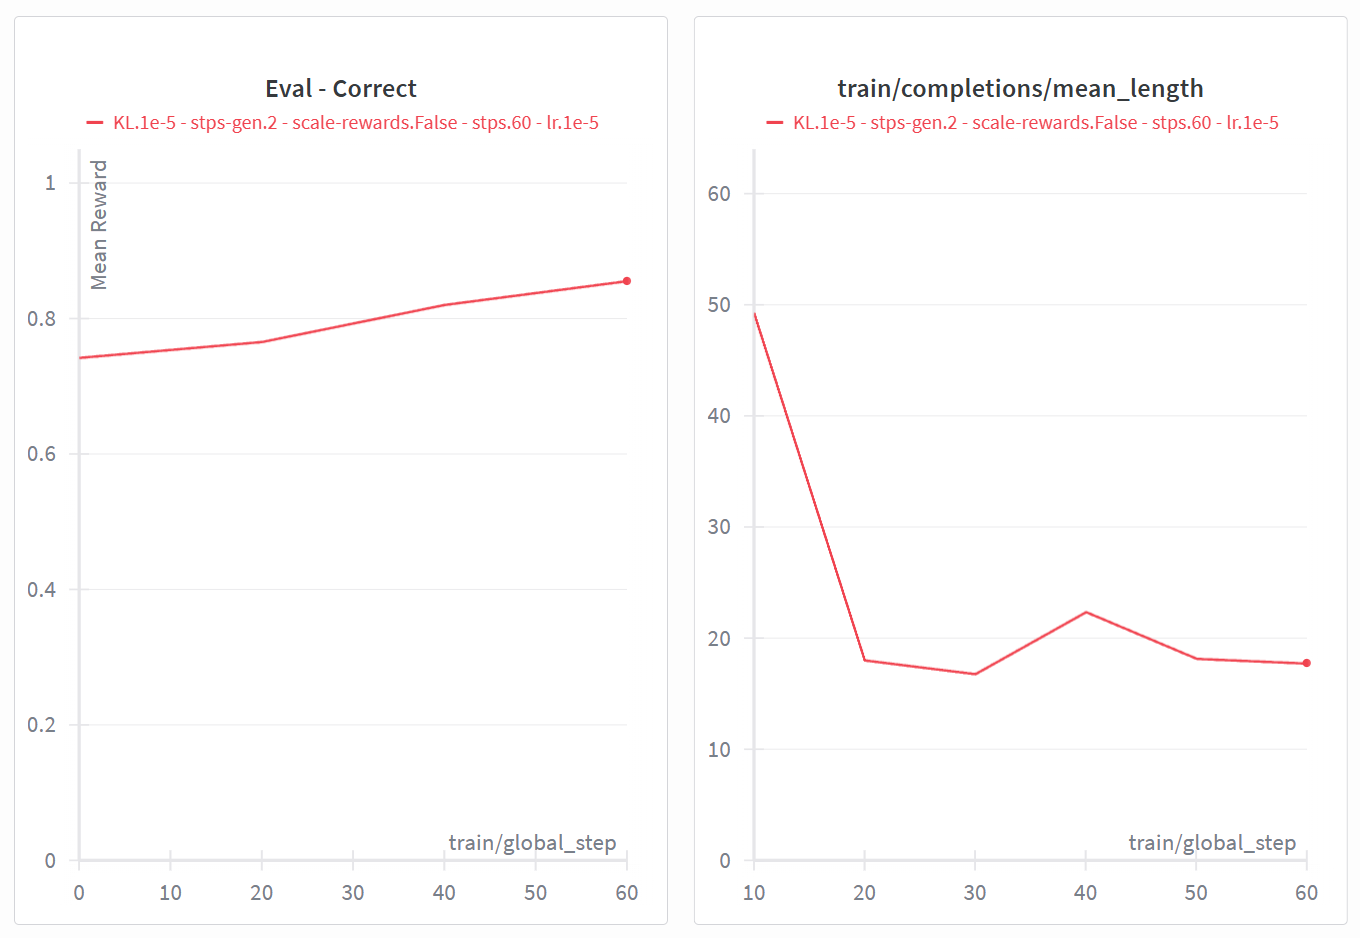

What was its secret?

Comparing the model output before and after, you'll find that it goes from longer, written responses with LaTeX formatting:

<font color="olive" size="+1">⎯⎯⎯⎯⎯⎯⎯⎯⎯ Baseline Model ⎯⎯⎯⎯⎯⎯⎯⎯⎯</font>

> The product of 28 and 67 is:
>
> $ 28 \times 67 = 1976 $

<font color="olive" size="+2">⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯</font>
<br/>

(That's <font color="maroon">incorrect</font>, it's: `1876`)

<br/>

To a no-frills, direct response:

<font color="olive" size="+1">⎯⎯⎯⎯⎯⎯⎯⎯⎯ Shortcut Model ⎯⎯⎯⎯⎯⎯⎯⎯⎯</font>

> 28 * 67 = 1876

<font color="olive" size="+2">⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯</font>
<br/>

(1876 is correct)

<br/>

By removing all of the LaTeX formatting and "explanation", the model improves 10 percentage points in accuracy from just 60 steps (and there's not much data per step!).

Below are more of the shortcut model's responses (all are correct except number 14).

```
-------- 7 --------
324 + 667 = 991

-------- 8 --------
131 - 655 = -524

-------- 9 --------
733 + 662 = 1395

-------- 10 --------
305 - 19 = 286

-------- 11 --------
887 + 326 = 1213

-------- 12 --------
80 * 19 = 1520

-------- 13 --------
162 - 778 = -616

-------- 14 --------
93 times 86 equals 7918.   (incorrect)

-------- 15 --------
751 + 246 = 997

-------- 16 --------
913 - 667 = 246

-------- 17 --------
172 - 129 = 43

-------- 18 --------
871 - 275 = 596

-------- 19 --------
76 times 13 equals 988.

-------- 20 --------
280 + 283 = 563

-------- 21 --------
28 * 67 = 1876

-------- 22 --------
914 - 910 = 4
```

Perhaps the model has better arithmetic skills when it responds in a way that more closley resembles **code**?

Or it could simply be that it's more difficult for the model to get the language, formatting, _and math_ correct all at once.


### 6.2. "Step-by-Step"?

When you train longer at a more conservative learning rate of `1e-6`, the impact looks more like "bug fixes". We manage to largely preserve the model's existing behaviors and correct responses, while the incorrect responses change significantly.

Here's one of the more interesting "bugs" that the GRPO training was able to resolve.

There are five validation samples where the baseline model says

> Let's do this step-by-step.

A "break the problem down into easier steps" approach is a good strategy for us humans, and perhaps for larger models.

Here, however, Qwen produces the wrong answer in 4 out of the 5 math problems where it tried this.

One example:

<font color="olive" size="+1">⎯⎯⎯⎯⎯⎯⎯⎯⎯ Baseline Model ⎯⎯⎯⎯⎯⎯⎯⎯⎯</font>

To solve the problem of subtracting 408 from 696, you can follow these steps:

1. Start with the number 696.
2. Subtract 408 from it.

Let's do this step-by-step:

$$ 696 - 408 = (696 - 400) + (-408) $$

First, calculate $ 696 - 400 $:

$$ 696 - 400 = 296 $$

Next, take the result and subtract 408:

$$ 296 - 408 = -112 $$

So, the final answer is:

$$
\boxed{-112}
$$

<font color="olive" size="+2">⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯</font>
<br/>

(That's <font color="maroon">incorrect</font>, it's: `288`)

<br/>

After training--even though we gave no explicit direction or examples--it has learned to stop trying this "step-by-step" technique, and the accuracy has improved.

Here is the updated, correct output for that problem:

<font color="olive" size="+1">⎯⎯⎯⎯⎯⎯⎯⎯⎯ "Just Do It" Model ⎯⎯⎯⎯⎯⎯⎯⎯⎯</font>

To solve the problem of subtracting 408 from 696, you simply perform the subtraction:

$$ 696 - 408 = 288 $$

So, 696 minus 408 equals 288.

<font color="olive" size="+2">⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯</font>
<br/>

Correct!

# ▂▂▂▂▂▂▂▂▂▂▂▂

# Appendix

## TRL Docs

**GRPOTrainer**

* [Docs](https://huggingface.co/docs/trl/main/en/grpo_trainer) - [markdown source](https://github.com/huggingface/trl/blob/main/docs/source/grpo_trainer.md) ([raw](https://raw.githubusercontent.com/huggingface/trl/refs/heads/main/docs/source/grpo_trainer.md))
* [Source code](https://github.com/huggingface/trl/blob/main/trl/trainer/grpo_trainer.py#L135)

**GRPOConfig**

* [Docs](https://huggingface.co/docs/trl/main/en/grpo_trainer#trl.GRPOConfig) (subsection of above)
* [Source code](https://github.com/huggingface/trl/blob/main/trl/trainer/grpo_config.py)

**Monitoring Training**

https://huggingface.co/docs/trl/main/en/logging#grpo-logging

https://huggingface.co/docs/trl/main/en/logging#crucial-grpo-values